In [89]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import csv
import pickle

In [31]:
lambdas = np.array([3, 5, 7, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200])
#lambdas = np.arange(1, 201)
warmup_period = lambdas.max()
polynomial_order = 8
x_max_length = 20

x_warmup = pd.read_csv('SPY-daily-2021-2023.csv', header=0, usecols=['Date', 'Close'], nrows=warmup_period)
x_data = pd.read_csv('SPY-daily-2021-2023.csv', header=0, usecols=['Date', 'Close'], skiprows=range(1,warmup_period+1))

In [57]:
class DataTransform:
    def __init__(self, x_data):
        self.x = x_data
        self.mu = np.zeros(len(lambdas))
        self.beta = np.zeros(polynomial_order+1)
        self.sigma = np.zeros(len(lambdas)+1)
        self.mu_slope = np.zeros(len(lambdas))
        self.mu_list = []
        #self.beta_df = []
        for i in range(1, len(self.x.index)):
            self.x.loc[i, 'Diff'] = self.x.loc[i, 'Close'] - self.x.loc[i-1, 'Close']
        
    def updateData(self, data_new):
        self.x = self.x.append(data_new, ignore_index=True)
        if len(self.x.index) > x_max_length:
            self.x.drop(index=0, inplace=True)
            self.x.reset_index(drop=True, inplace=True)
        for i in range(1, len(self.x.index)):
            self.x.loc[i, 'Diff'] = self.x.loc[i, 'Close'] - self.x.loc[i-1, 'Close']
            
        return self.x
        
    def warmupSMA(self, x_data):
        #x_data = np.pad(x_data, (lambdas.max(), 0), 'edge')
        t0 = len(x_data)
        
        for i, l in enumerate(lambdas):
            data = x_data[t0-l : t0]
            self.mu[i] = np.mean(data)
        return self.mu
    
    def updateMu(self, x_new):
        # run BEFORE updataData since this requires oldest data value, x(t0 - lambda.max)
        # delta_mu ~ dmu/dt = (x(t) - x(t-lambda)) / lambda
        
        for i, l in enumerate(lambdas):
            t0 = len(self.x.index)
            x_old = self.x.loc[t0-l, 'Close']
            delta_mu = (x_new - x_old)/l
            self.mu[i] = self.mu[i] + delta_mu
            self.mu_slope[i] = delta_mu
        
        return self.mu
    
    def updateBeta(self):
        self.beta = np.polyfit(lambdas, self.mu, polynomial_order)
        return self.beta
    
    def updateSigma(self):
        for i in range(2, len(lambdas)+1):
            # take the standard deviation of the first i EMAs
            self.sigma[i] = np.std(self.mu[:i])
            
        return self.sigma
    
    def step(self, data_new):
        self.updateMu(data_new['Close'])  # update mu before data since mu requires all old data
        self.updateData(data_new)
        self.updateBeta()
        self.updateSigma()
        
    def append_mu(self, date):
        new_mu = {l: self.mu[i] for i, l in enumerate(lambdas)}
        new_mu['Date'] = date
        self.mu_list.append(new_mu)
        
    def batchMu(self, data, warmup_data):
        full_data = np.concatenate((warmup_data, data))
        t0 = len(warmup_data)
        mu = np.zeros((len(data), len(lambdas)))
        
        for i, l in enumerate(lambdas):
            for j in range(len(data)):
                window = full_data[t0+j+1-l : t0+j+1]
                mu[j, i] = np.mean(window)
        return mu
    
    def batchBeta(self, mu):
        betas = np.zeros((mu.shape[0], polynomial_order+1))
        for i in range(mu.shape[0]):
            betas[i] = np.polyfit(lambdas, mu[i], polynomial_order)
        return betas
    
    def batchSigma(self, mu):
        return
    
    def batchSlope(self):
        return
    
    def x_from_mu(mu, lambdas):
        # Gives the average value of x between all neighboring values of mu_lambda
        # Time-reversed array is easier to calculate with the ordering of lambda and mu_lambda
        # So we flip the output array

        lambdas = np.insert(lambdas, 0, 0)  # pad with first element=0
        mu = np.insert(mu, 0, 0)
        x_bar = np.zeros(lambdas.max())

        for i in range(len(lambdas)-1):
            x_bar[lambdas[i]:lambdas[i+1]] = (lambdas[i+1]*mu[i+1] - lambdas[i]*mu[i])/(lambdas[i+1] - lambdas[i])

        return np.flip(x_bar)

In [90]:
class DataPrep:
    def __init__(self, data):
        self.sample = []
        for i in range(len(data)-x_max_length-1):
            window = data.loc[i:i+x_max_length, 'Close'].values
            delta = data.loc[i+x_max_length+1, 'Diff']
            self.sample.append({'data': window, 'target': delta})
        
    def write_dict(self):
        with open('data.csv', 'w', newline='') as csvfile:
            fieldnames = ['data', 'target']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            writer.writeheader()
            writer.writerows(self.sample)
            
    def read_dict(self):
        sample = []
        with open('data.csv', newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                row_data = np.array(row['data'])
                row_target = float(row['target'])
                sample.append({'data': row_data, 'target': row_target})
        return sample
    
    def write_pickle(self):
        with open('data.txt', 'wb') as handle:
            pickle.dump(self.sample, handle)
        
    def read_pickle(self):
        with open('data.txt', 'rb') as handle:
            sample = pickle.loads(handle.read())
        return sample

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = F.log_softmax(x, dim=1)
        return x
    
def loss_fn(predictions, target):
    return F.nll_loss(predictions, target)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#input_size = 784
#num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 1

In [ ]:
model = NN(input_size=input_size, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [59]:
# Initialize all data/transforms

dt = DataTransform(x_warmup)
dt.warmupSMA(x_warmup['Close'].values)
dt.updateBeta()
dt.updateSigma()

dt.x

,Date,Close,Diff
0,2021-03-15,396.410004,NaN
1,2021-03-16,395.910004,-0.500000
2,2021-03-17,397.260010,1.350006
3,2021-03-18,391.480011,-5.779999
4,2021-03-19,389.480011,-2.000000
...,...,...,...
195,2021-12-20,454.980011,-4.889984
196,2021-12-21,463.059998,8.079987
197,2021-12-22,467.690002,4.630004
198,2021-12-23,470.600006,2.910004


In [91]:
dp = DataPrep(dt.x)

In [76]:
dp.sample

[{'data': array([396.410004, 395.910004, 397.26001 , 391.480011, 389.480011,
         392.589996, 389.5     , 387.519989, 389.700012, 395.980011,
         395.779999, 394.730011, 396.329987, 400.609985, 406.359985,
         406.119995, 406.589996, 408.519989, 411.48999 , 411.640015,
         412.859985]),
  'target': -1.4099729999999795},
 {'data': array([395.910004, 397.26001 , 391.480011, 389.480011, 392.589996,
         389.5     , 387.519989, 389.700012, 395.980011, 395.779999,
         394.730011, 396.329987, 400.609985, 406.359985, 406.119995,
         406.589996, 408.519989, 411.48999 , 411.640015, 412.859985,
         411.450012]),
  'target': 4.419983000000002},
 {'data': array([397.26001 , 391.480011, 389.480011, 392.589996, 389.5     ,
         387.519989, 389.700012, 395.980011, 395.779999, 394.730011,
         396.329987, 400.609985, 406.359985, 406.119995, 406.589996,
         408.519989, 411.48999 , 411.640015, 412.859985, 411.450012,
         415.869995]),
  'target': 1

In [92]:
dp.write_pickle()

In [93]:
dp.read_pickle()

[{'data': array([396.410004, 395.910004, 397.26001 , 391.480011, 389.480011,
         392.589996, 389.5     , 387.519989, 389.700012, 395.980011,
         395.779999, 394.730011, 396.329987, 400.609985, 406.359985,
         406.119995, 406.589996, 408.519989, 411.48999 , 411.640015,
         412.859985]),
  'target': -1.4099729999999795},
 {'data': array([395.910004, 397.26001 , 391.480011, 389.480011, 392.589996,
         389.5     , 387.519989, 389.700012, 395.980011, 395.779999,
         394.730011, 396.329987, 400.609985, 406.359985, 406.119995,
         406.589996, 408.519989, 411.48999 , 411.640015, 412.859985,
         411.450012]),
  'target': 4.419983000000002},
 {'data': array([397.26001 , 391.480011, 389.480011, 392.589996, 389.5     ,
         387.519989, 389.700012, 395.980011, 395.779999, 394.730011,
         396.329987, 400.609985, 406.359985, 406.119995, 406.589996,
         408.519989, 411.48999 , 411.640015, 412.859985, 411.450012,
         415.869995]),
  'target': 1

In [41]:
# Step forward with new data

for t in range(len(x_data.index)):
    dt.step(x_data.loc[t])
    dt.append_mu(x_data.loc[t]['Date'])

dt.x

,Date,Close
0,2021-12-28,476.869995
1,2021-12-29,477.480011
2,2021-12-30,476.160004
3,2021-12-31,474.959991
4,2022-01-03,477.709991
...,...,...
299,2023-03-08,398.920013
300,2023-03-09,391.559998
301,2023-03-10,385.910004
302,2023-03-13,385.359985


In [79]:
mu_array = dt.batchMu(x_data['Close'].values, x_warmup['Close'].values)
mu_df = pd.DataFrame(mu_array, columns=lambdas)
mu_df

,3,5,7,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200
0,474.910004,471.096002,467.190002,467.074002,464.393501,465.337003,465.329501,463.063001,458.636167,455.499715,454.525626,453.942668,452.870001,450.175000,446.725928,443.035875,440.086555,435.980150
1,477.203339,473.980005,469.705719,468.486005,465.489502,465.672003,465.765501,463.668801,459.450167,456.120287,454.830626,454.321779,453.219901,450.524667,447.110714,443.486312,440.453388,436.388000
2,476.836670,475.674005,472.731432,469.042004,466.772502,465.901337,466.122002,464.179201,460.167834,456.727858,455.139376,454.642890,453.560201,450.850334,447.481071,443.898062,440.788333,436.782500
3,476.200002,476.546002,474.431431,469.893002,467.650502,466.128669,466.378001,464.630201,460.835501,457.257858,455.440001,454.942779,453.883001,451.178417,447.836071,444.262937,441.108888,437.199899
4,476.276662,476.635998,475.862858,471.677002,468.865001,466.394668,466.648001,465.112601,461.486334,457.751144,455.799126,455.262779,454.222301,451.524000,448.216285,444.651625,441.456111,437.641049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,400.553334,400.732001,399.237143,398.943002,403.391502,405.021001,402.670001,398.670800,397.125834,397.511571,397.440625,395.481000,393.088500,389.390834,391.761715,394.073438,392.785778,393.204201
300,396.250000,399.482001,398.565713,398.033002,402.437003,404.728001,402.694501,398.843800,397.097167,397.357714,397.401500,395.609667,393.344400,389.402834,391.511072,394.053376,392.877389,393.213851
301,392.130005,395.826001,397.304286,396.986002,401.378003,404.100001,402.454251,398.934000,396.879834,397.214857,397.244000,395.575111,393.627200,389.405750,391.211215,393.972876,392.941389,393.158801
302,387.609996,392.003998,395.525713,395.748999,400.244002,403.422667,402.164251,399.108000,396.603000,397.073857,397.122000,395.565667,393.812600,389.379167,390.948501,393.912063,392.981945,393.116150


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

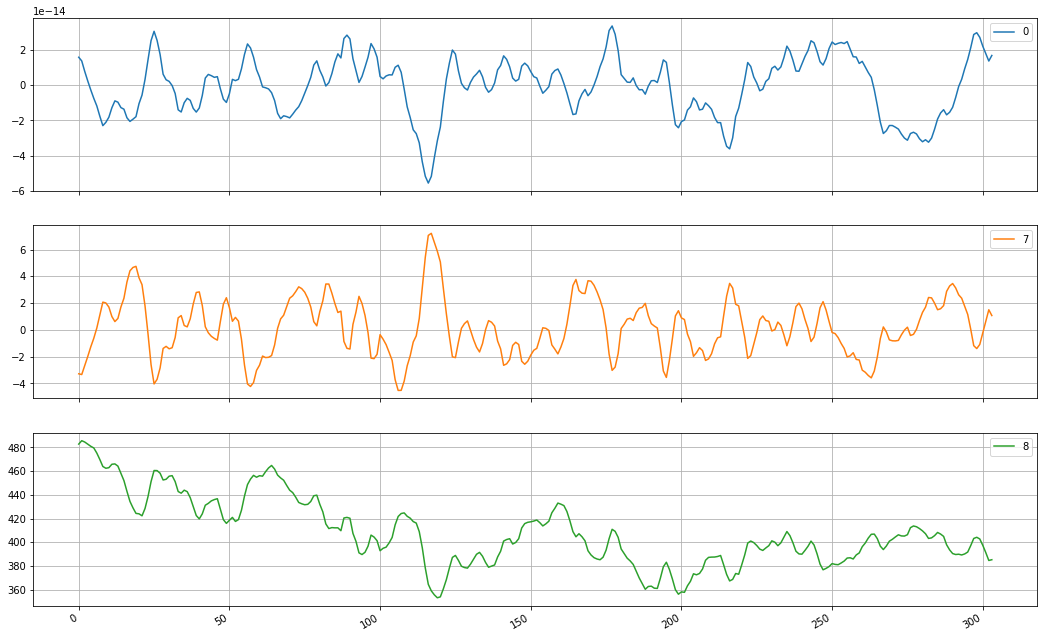

In [89]:
beta_array = dt.batchBeta(mu_array)
beta_df = pd.DataFrame(beta_array)
beta_df[[0, polynomial_order-1, polynomial_order]].plot(figsize=(18,12), subplots=True, grid=True)

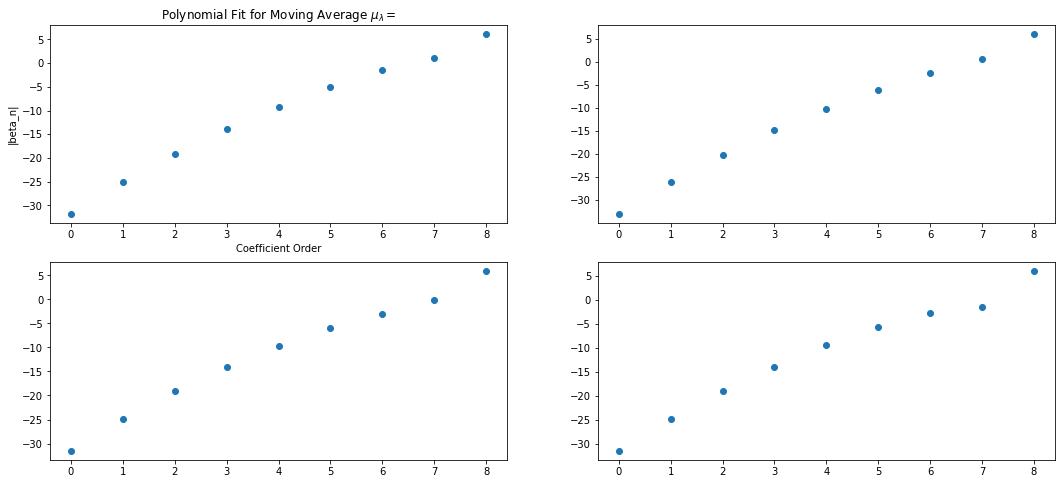

In [125]:
log_abs_beta = np.log(np.abs(beta_array))

fig, ax = plt.subplots(2,2, figsize=(18,8))
ax[0,0].set_title("Polynomial Fit for Moving Average $\mu_\lambda=\beta_0\lambda^n+\dots+\beta_n$")
ax[0,0].set_ylabel("|beta_n|")
ax[0,0].set_xlabel("Coefficient Order")
ax[0,0].scatter(x=np.arange(polynomial_order+1), y=log_abs_beta[0])
ax[0,1].scatter(x=np.arange(polynomial_order+1), y=log_abs_beta[50])
ax[1,0].scatter(x=np.arange(polynomial_order+1), y=log_abs_beta[200])
ax[1,1].scatter(x=np.arange(polynomial_order+1), y=log_abs_beta[300])
#ax.set_yscale('log')

In [97]:
pd.DataFrame(log_abs_beta)

,0,1,2,3,4,5,6,7,8
0,-31.768143,-24.994339,-19.105454,-13.848292,-9.153228,-5.026703,-1.540319,1.187754,6.179641
1,-31.909901,-25.124719,-19.223172,-13.951635,-9.239702,-5.092132,-1.576096,1.204541,6.185550
2,-32.476353,-25.644074,-19.696526,-14.380289,-9.625100,-5.435427,-1.875986,0.976071,6.183205
3,-33.643773,-26.601239,-20.491482,-15.045827,-10.185248,-5.908223,-2.272748,0.684587,6.179592
4,-33.565215,-27.250690,-22.292815,-17.568163,-11.545028,-6.854758,-2.980745,0.231920,6.175769
...,...,...,...,...,...,...,...,...,...
299,-31.231836,-24.574618,-18.818212,-13.712206,-9.191846,-5.276844,-2.085354,0.085180,5.998347
300,-31.436842,-24.793357,-19.055878,-13.977021,-9.498382,-5.657194,-2.645104,-1.469458,5.984976
301,-31.648972,-25.024267,-19.314285,-14.278180,-9.873353,-6.191079,-3.841894,-0.468844,5.969309
302,-31.912833,-25.319873,-19.659081,-14.707213,-10.477227,-7.416070,-3.555994,0.409656,5.952229


In [121]:
lab_slope = np.zeros((log_abs_beta.shape[0], 2))
for i in range(log_abs_beta.shape[0]):
    lab_slope[i] = np.polyfit(np.arange(polynomial_order+1), log_abs_beta[i], 1)

In [42]:
pd.DataFrame.from_dict(dt.mu_list)

,3,5,7,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200,Date
0,474.910004,471.096002,467.190002,467.074002,464.393501,465.337003,465.329501,463.063001,458.636167,455.499715,454.525626,453.942668,452.870001,450.175000,446.725928,443.035875,440.086555,435.980150,2021-12-28
1,477.203339,473.980005,469.705719,468.486005,465.489502,465.672003,465.765501,463.668801,459.450167,456.120287,454.830626,454.321779,453.219901,450.524667,447.110714,443.486312,440.453388,436.388000,2021-12-29
2,476.836670,475.674005,472.731432,469.042004,466.772502,465.901337,466.122002,464.179201,460.167834,456.727858,455.139376,454.642890,453.560201,450.850334,447.481071,443.898062,440.788333,436.782500,2021-12-30
3,476.200002,476.546002,474.431431,469.893002,467.650502,466.128669,466.378001,464.630201,460.835501,457.257858,455.440001,454.942779,453.883001,451.178417,447.836071,444.262937,441.108888,437.199899,2021-12-31
4,476.276662,476.635998,475.862858,471.677002,468.865001,466.394669,466.648001,465.112601,461.486334,457.751144,455.799126,455.262779,454.222301,451.524000,448.216285,444.651625,441.456111,437.641049,2022-01-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,400.553334,400.732001,399.237143,398.943002,403.391502,405.021001,402.670001,398.670800,397.125834,397.511571,397.440625,395.481000,393.088500,389.390834,391.761715,394.073438,392.785778,393.204201,2023-03-08
300,396.250000,399.482001,398.565713,398.033002,402.437003,404.728001,402.694501,398.843800,397.097167,397.357714,397.401500,395.609667,393.344400,389.402834,391.511072,394.053376,392.877389,393.213851,2023-03-09
301,392.130005,395.826001,397.304286,396.986002,401.378003,404.100001,402.454251,398.934000,396.879834,397.214857,397.244000,395.575111,393.627200,389.405750,391.211215,393.972876,392.941389,393.158801,2023-03-10
302,387.609996,392.003998,395.525713,395.748999,400.244002,403.422667,402.164251,399.108000,396.603000,397.073857,397.122000,395.565667,393.812600,389.379167,390.948501,393.912063,392.981945,393.116150,2023-03-13


<Axes: ylabel='Frequency'>

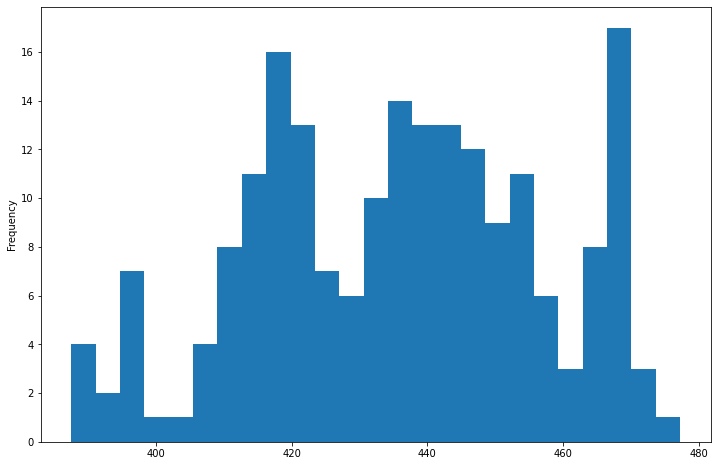

In [16]:
dt.x['Close'].plot(kind='hist', bins=25, figsize=(12,8))

In [11]:
x_norm = (dt.x['Close'] - dt.x['Close'].mean())/dt.x['Close'].std()

(array([ 4.,  3.,  8., 20., 35., 60., 35., 23., 10.,  2.]),
 array([-3.21955844, -2.62859951, -2.03764058, -1.44668165, -0.85572272,
        -0.26476379,  0.32619514,  0.91715407,  1.508113  ,  2.09907193,
         2.69003085]),
 <BarContainer object of 10 artists>)

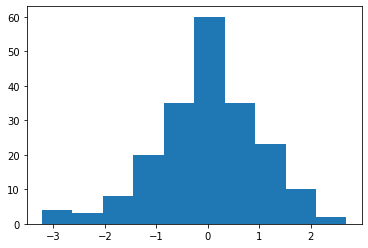

In [33]:
x_diff = np.zeros(len(dt.x.index))
for i in range(1, len(dt.x.index)):
    x_diff[i] = dt.x['Close'][i] - dt.x['Close'][i-1]
x_diff_norm = (x_diff - np.mean(x_diff))/np.std(x_diff)
plt.hist(x_diff_norm)

<Axes: >

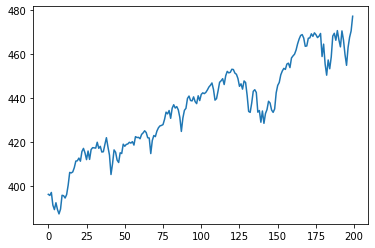

In [36]:
dt.x['Close'].plot()

In [37]:
np.mean(x_diff)

0.40425002999999976

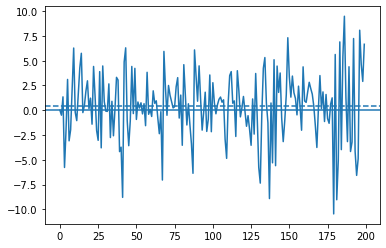

In [41]:
plt.plot(x_diff)
plt.axhline(y=0)
plt.axhline(y=np.mean(x_diff), linestyle='--')

<Axes: ylabel='Frequency'>

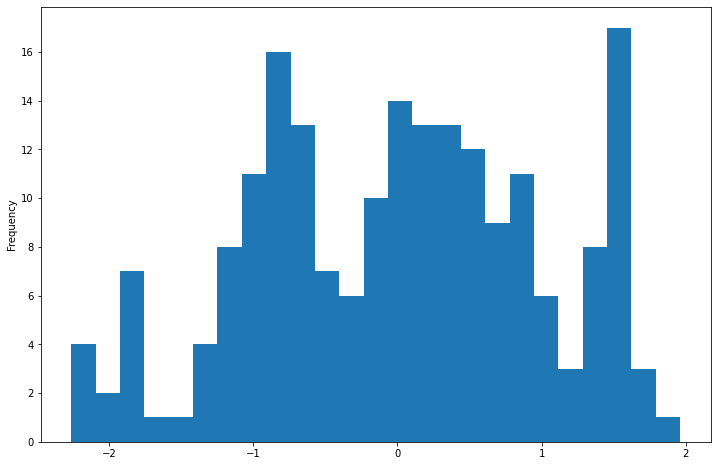

In [15]:
x_norm.plot(kind='hist', bins=25, figsize=(12,8))

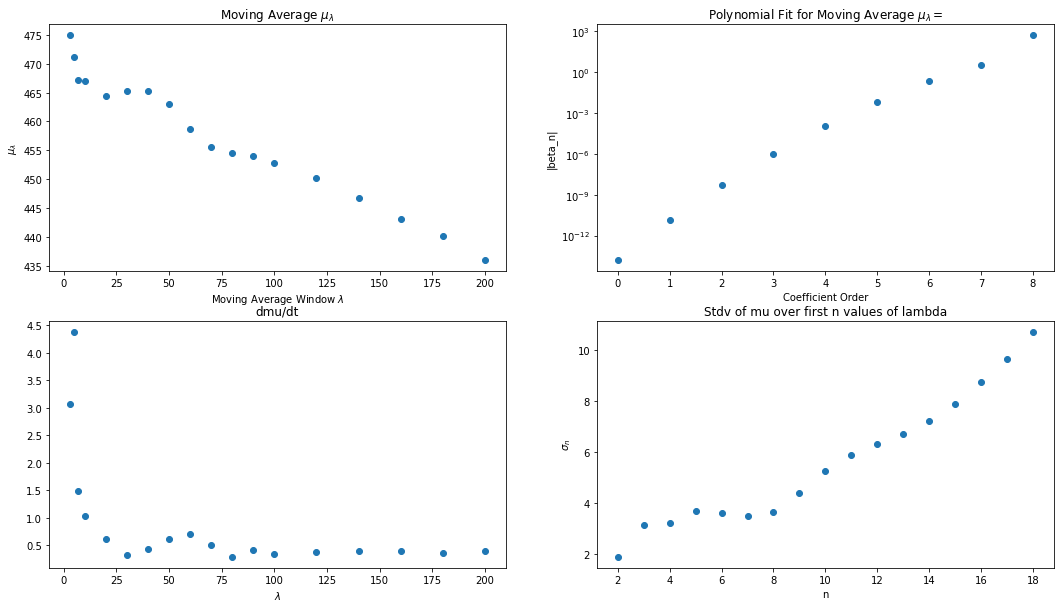

In [71]:
fig, ax = plt.subplots(2, 2, figsize=(18, 10))
ax[0,0].set_title("Moving Average $\mu_\lambda$")
ax[0,0].set_xlabel("Moving Average Window $\lambda$")
ax[0,0].set_ylabel("$\mu_\lambda$")
ax[0,0].scatter(x=lambdas, y=dt.mu)

ax[0,1].set_title("Polynomial Fit for Moving Average $\mu_\lambda=\beta_0\lambda^n+\dots+\beta_n$")
ax[0,1].set_ylabel("|beta_n|")
ax[0,1].set_xlabel("Coefficient Order")
ax[0,1].scatter(x=np.arange(len(dt.beta)), y=np.abs(dt.beta))
ax[0,1].set_yscale('log')

ax[1,0].set_title("dmu/dt")
ax[1,0].set_xlabel("$\lambda$")
ax[1,0].scatter(x=lambdas, y=dt.mu_slope)

ax[1,1].set_title("Stdv of mu over first n values of lambda")
ax[1,1].set_ylabel("$\sigma_n$")
ax[1,1].set_xlabel("n")
ax[1,1].scatter(x=np.arange(2, len(lambdas)+1), y=dt.sigma[2:])

plt.show()

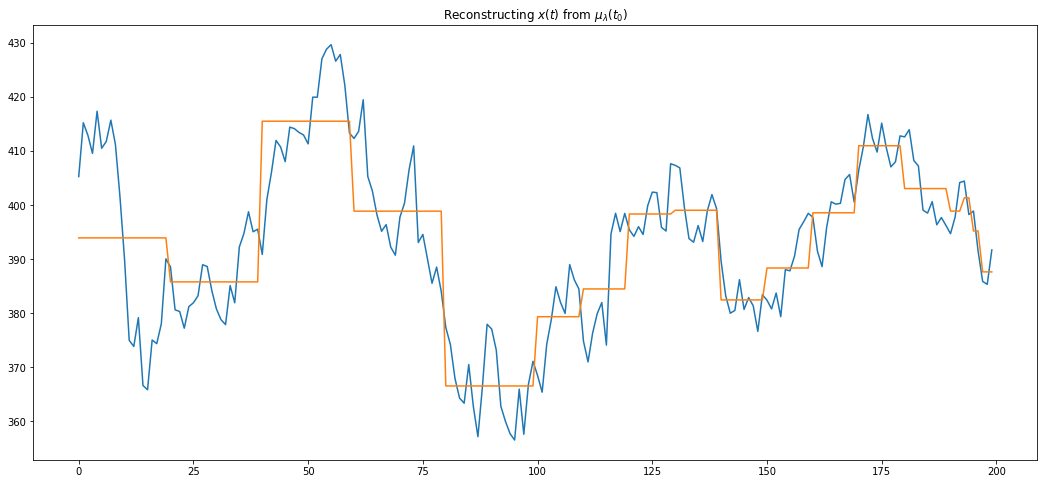

In [66]:
t0 = len(dt.x.index)
x_bar = np.empty(t0)
x_bar[t0-lambdas.max():] = x_from_mu(dt.mu, lambdas)

fig, ax = plt.subplots(figsize=(18, 8))

ax.plot(dt.x['Close'][t0-lambdas.max():].values)
ax.plot(x_bar[t0-lambdas.max():])

ax.set_title('Reconstructing $x(t)$ from $\mu_\lambda(t_0)$')
plt.show()

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

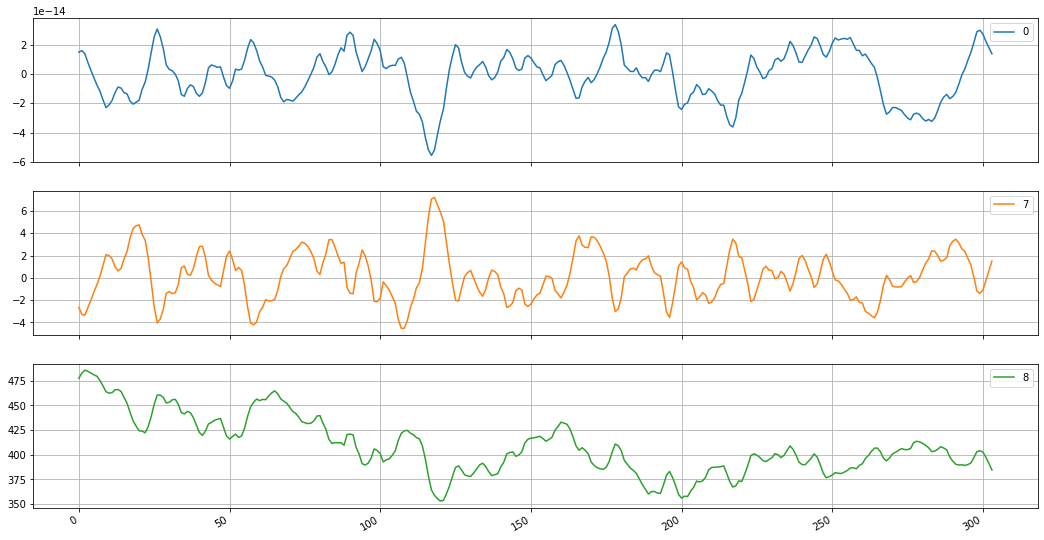

In [483]:
beta[[0, order-1, order]].plot(figsize=(18,10), grid=True, subplots=True)

<font size="5"> **Compute EMA Depth And Test Trade Signals**</font>

**This indicator creates an array of EMAs of various periods. It then tracks how many of these EMAs the price is above and below. The number of EMAs the price is above is called the Depth. It can range from 0 to the number of EMAs. We create a buy/sell trigger when the Depth rises above or below a threshold. Reults of testing are given for all values of the threshold.**

In [484]:
maxDepth = len(lambdas)

# Counts the number of EMAs the price is above at each time step
def countDepth(df, mu):
    countArray = np.zeros(len(df.index))
    
    for i in range(len(df.index)):
        count = 0
        for l in lambdas:
            if df.loc[i, 'Close'] > mu.loc[i, l]:
                count += 1
        countArray[i] = count
    return countArray

In [485]:
# Given a continuous signal, generate a +1 if the signal crosses above a threshold, and -1 if it crosses under
def trigger(signal, threshold):
    triggers = np.zeros(len(signal))
    
    prevVal = signal[0]
    
    for index, val in enumerate(signal):
        if val >= threshold and prevVal < threshold:
            triggers[index] = 1    # indicates a cross-over
        if val < threshold and prevVal >= threshold:
            triggers[index] = -1   # indicates a cross-under
            
        prevVal = val
        
    return triggers

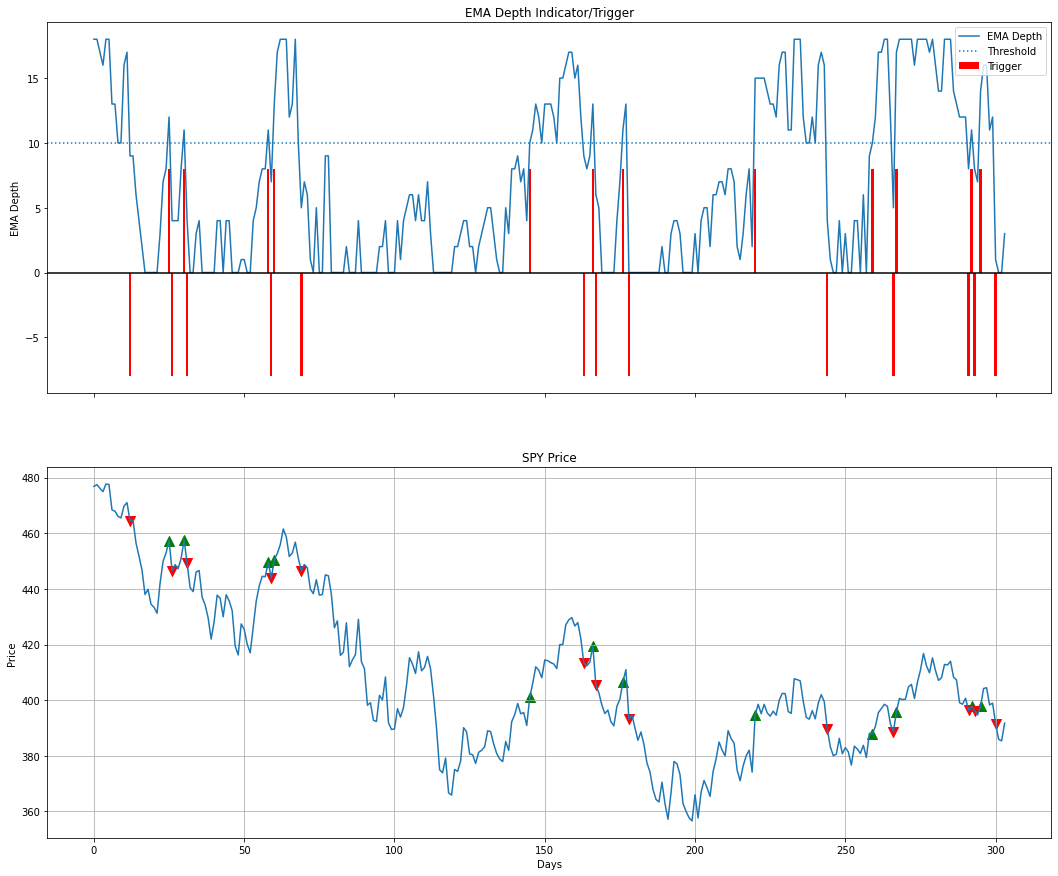

In [486]:
thresh = 10
X = df.index.values
depth = countDepth(df, mu)
triggers = trigger(countDepth(df, mu), thresh)

pos = [i for i, v in enumerate(triggers) if v==1]
neg = [i for i, v in enumerate(triggers) if v==-1]
pos_price = df.loc[pos, 'Close']
neg_price = df.loc[neg, 'Close']

fig, ax = plt.subplots(2, figsize=(18,15), sharex=True)

ax[0].plot(depth)
ax[0].axhline(y=thresh, linestyle='dotted')

ax[0].bar(X, 8*triggers, color='red')
ax[0].legend(('EMA Depth', 'Threshold', 'Trigger'), loc='upper right')

ax[0].axhline(y=0, color='black')
ax[0].set_title('EMA Depth Indicator/Trigger')
ax[0].set_ylabel('EMA Depth')

ax[1].plot(df['Close'])
ax[1].scatter(pos, pos_price, color='green', marker='^', s=100)
ax[1].scatter(neg, neg_price, color='red', marker='v', s=100)
ax[1].grid()
ax[1].set_title('SPY Price')
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Price')

fig.savefig("EMA Depth Indicator th=10.pdf", bbox_inches='tight')

plt.show()

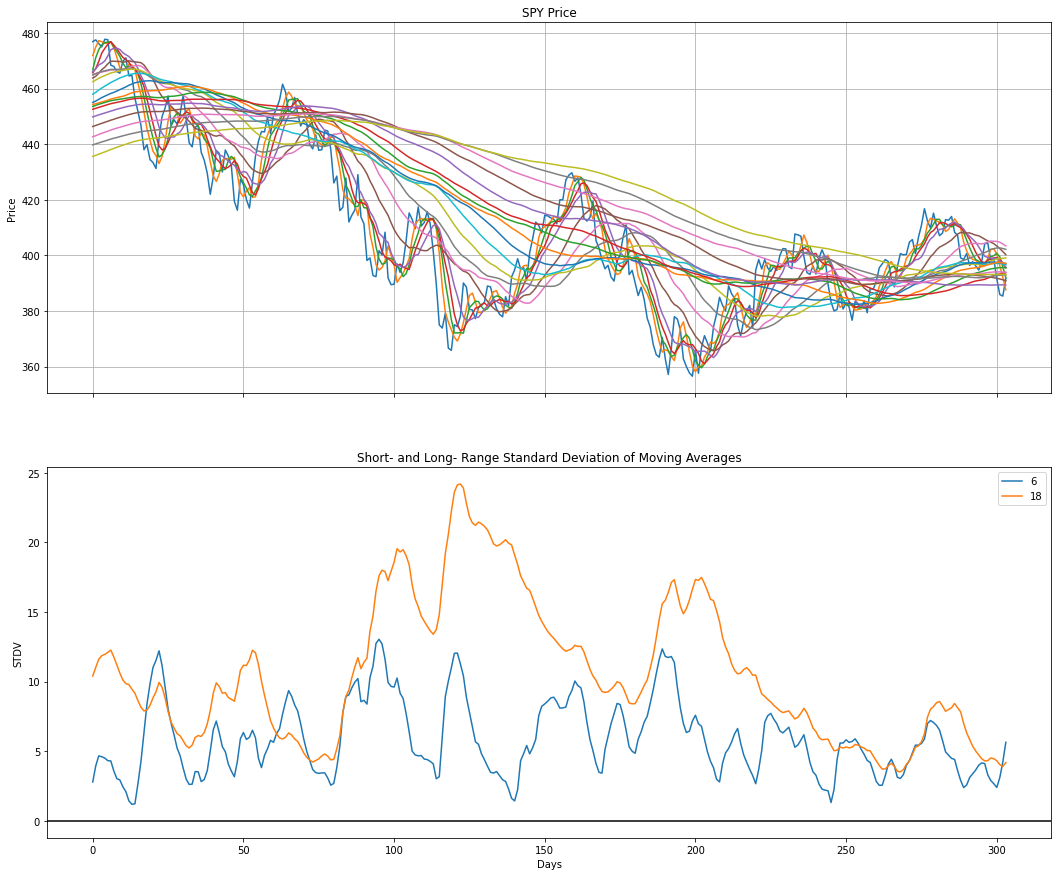

In [490]:
fig, ax = plt.subplots(2, figsize=(18,15), sharex=True)

ax[0].plot(df['Close'])
ax[0].plot(mu)
ax[0].grid()
ax[0].set_title('SPY Price')
ax[0].set_ylabel('Price')

ax[1].plot(sigma[[6, 18]])
ax[1].axhline(y=0, color='black')

ax[1].legend(('6', '18'), loc='upper right')
ax[1].set_title('Short- and Long- Range Standard Deviation of Moving Averages')
ax[1].set_ylabel('STDV')
ax[1].set_xlabel('Days')

fig.savefig("Moving Average STDV-6-18.pdf", bbox_inches='tight')

plt.show()

<font size="5">**Compute the Veclocity of the Moving Averages**</font>

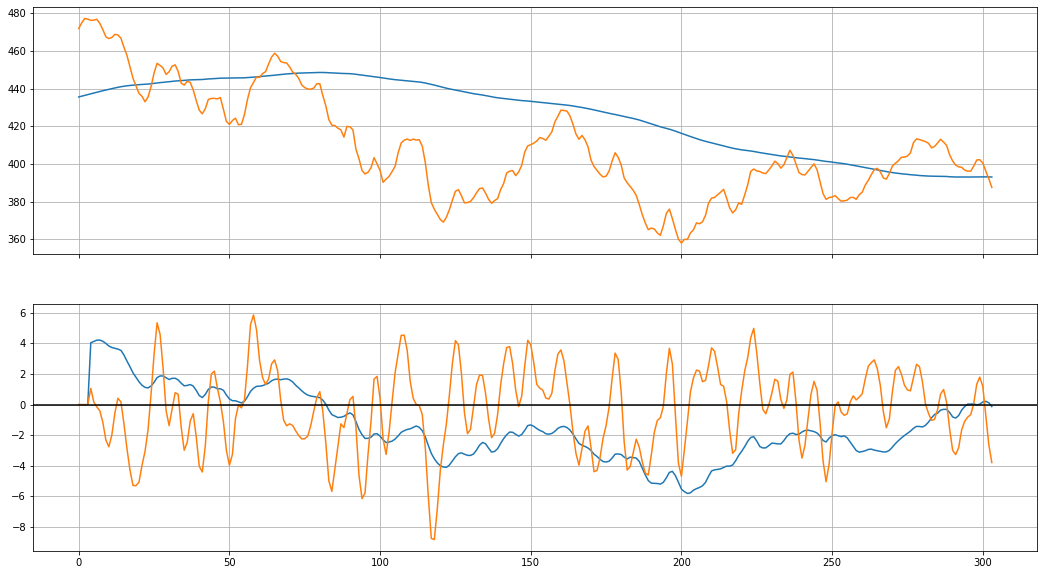

In [493]:
fig, ax = plt.subplots(2, figsize=(18,10), sharex=True)

ax[0].plot(mu[200])
ax[0].plot(mu[3])

ax[1].plot(10*slopes[200])
ax[1].plot(slopes[3])
ax[1].axhline(y=0, color='black')

ax[0].grid()
ax[1].grid()

plt.show()

<font size="5">**Compute the Fourier Spectrum of the Normalized Price, $\bar{x}(t) = x(t) - \mu_\lambda(t)$. $\bar{x}(\nu) = \mathcal{F}[\bar{x}(t)]$**</font>

In [ ]:
from scipy.fftpack import fft, ifft

xbar = np.zeros((len(df.index), len(lambdas)))
for i, l in enumerate(lambdas):
    xbar[:, i] = df['Close'].values - mu[l]
dfbar = pd.DataFrame(xbar, columns=lambdas)

In [ ]:
dfbar

In [ ]:
dfbar.plot(figsize=(18,10), grid=True)

In [ ]:
fft(dfbar[3].values)

In [ ]:
xfreq = np.zeros((len(dfbar.index), len(lambdas)))
for i, l in enumerate(lambdas):
    xfreq[:, i] = fft(dfbar[l].values)
#xfreqdf = pd.DataFrame(xfreq, columns=lambdas)

xfreq

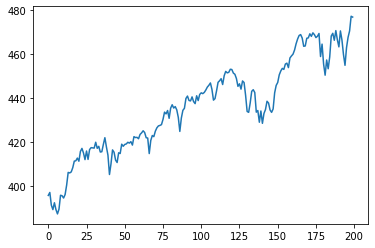

In [228]:
plt.plot(dt.x['Close'])

In [208]:
from scipy import signal
from scipy.fft import fftshift

In [263]:
x_data_long = pd.read_csv('SPY-daily-2020-2023.csv', header=0, usecols=['Date', 'Close'])

In [280]:
x_data_long.shape

(808, 2)

In [271]:
f, t, Sxx = signal.spectrogram(x_data_long['Close'].values, nperseg=20)

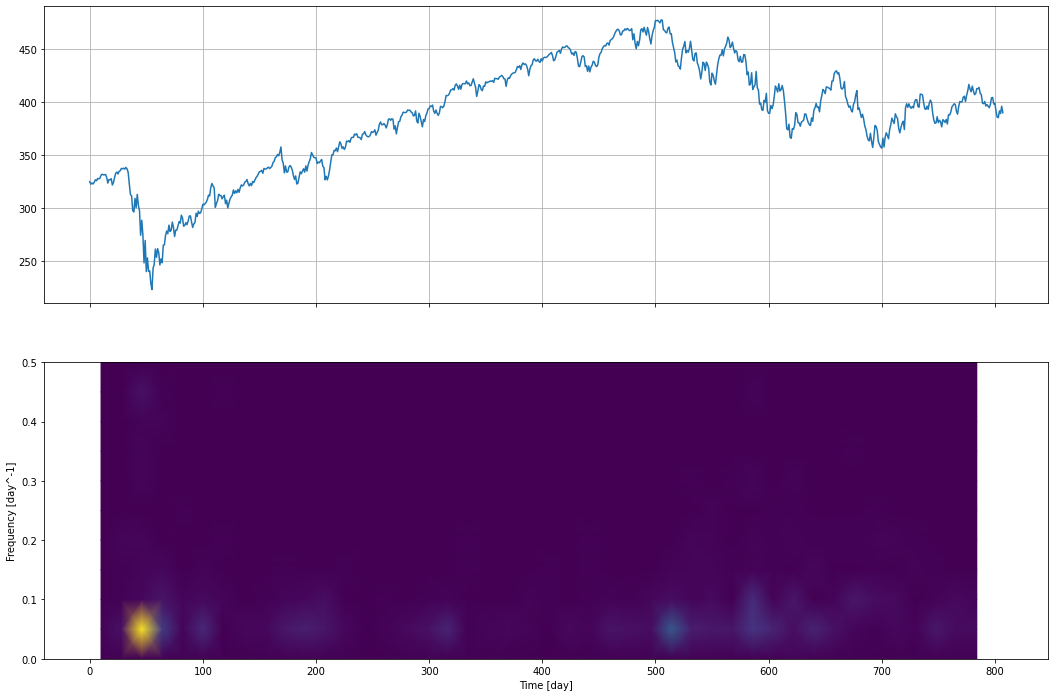

In [265]:
fig, ax = plt.subplots(2, figsize=(18,12), sharex=True)

ax[0].plot(x_data_long['Close'])
ax[0].grid()

ax[1].pcolormesh(t, f, Sxx, shading='gouraud')
ax[1].set_ylabel('Frequency [day^-1]')
ax[1].set_xlabel('Time [day]')

plt.show()

In [272]:
Sxx.shape

(11, 44)

In [258]:
t.shape

(60,)

In [260]:
f

array([0. , 0.2, 0.4])

In [273]:
import librosa
import librosa.display

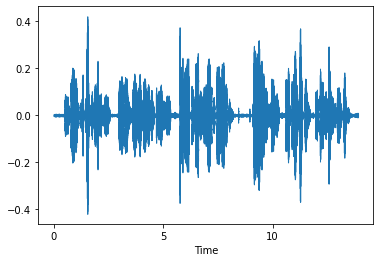

In [275]:
n_fft = 2048
hop_length = 512
n_mels = 128

example_name = 'libri3'
filename = librosa.example(example_name)
y, sr = librosa.load(filename)
# trim silent edges
y, _ = librosa.effects.trim(y)
librosa.display.waveshow(y, sr=sr);

In [279]:
y.shape

(306717,)

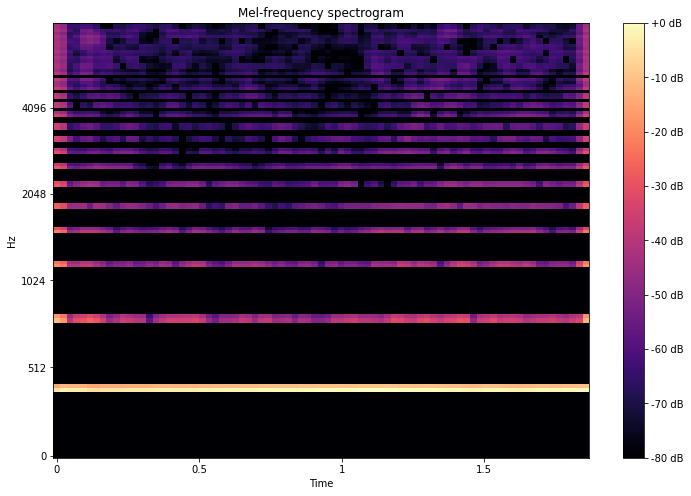

In [287]:
S = librosa.feature.melspectrogram(y=x_data_long['Close'].to_numpy(), sr=sr, n_fft=50, hop_length=10, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)

fig, ax = plt.subplots(figsize=(12,8))
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
plt.show()

In [278]:
import IPython.display as ipd

#xbar = df['Close'] - mu[30]
#plt.plot(xbar)
ipd.Audio(y, rate=20000)

In [504]:
sr = 22050 # sample rate
T = 1.0    # seconds
t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
x = 0.5*np.sin(2*np.pi*440*t)              # pure sine wave at 440 Hz
ipd.Audio(x, rate=sr)

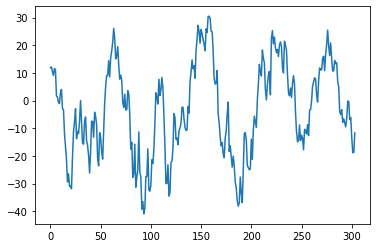

In [506]:
plt.plot(xbar)